In [12]:
import tensorflow_datasets as tfds
#TFDSで花のデータセットを読み込むデータはdatasetへ情報はinfoへ格納される
dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)



In [13]:
#infoからデータの数を取得
dataset_size = info.splits["train"].num_examples
#infoからラベル名を取得
class_names = info.features["label"].names
#infoからクラス数を取得
n_classes = info.features["label"].num_classes
#取得した情報を表示
print(dataset_size)
print(class_names)
print(n_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


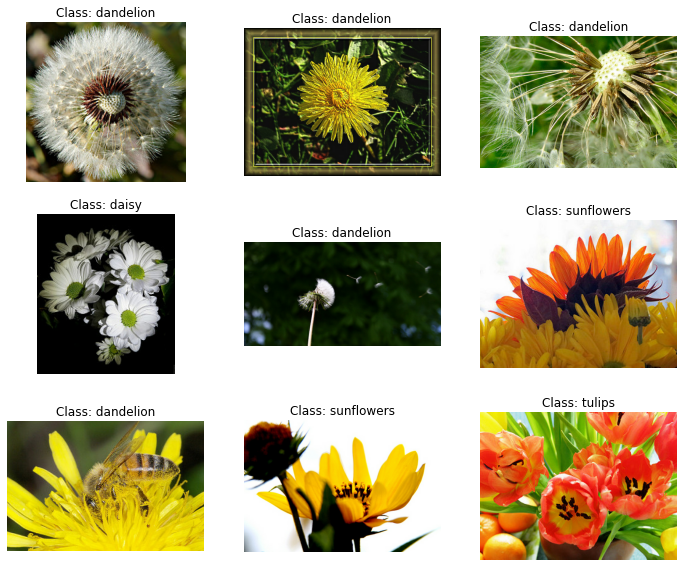

In [18]:

#データセットの先頭10%をテスト用、次の15%を検証用、残りの75%を訓練用にする。
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",split=["train[:10%]", "train[10%:25%]", "train[25%:]"],as_supervised=True)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [24]:
import tensorflow as tf
import keras
#CNNの入力は244x244であるため合わせる
def preprocess(image, lavel):
    resized_image = tf.image.resize(image, [244, 244])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [25]:
batch_size = 32
#データをプリフェッチする
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)




In [47]:
#ImageNetで学習したXceptionモデルをロード。include_topをFalseにしてネットワークの最上位を取り除く
base_model = keras.applications.xception.Xception(weights="imagenet", include_top = False)
#ベースモデルの出力に独自のグローバル平均プーリング層と全結合層を接続する
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation = "softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_12
13 block2_pool
14 batch_normalization_12
15 add_36
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_13
23 block3_pool
24 batch_normalization_13
25 add_37
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_14
33 block4_pool
34 batch_normalization_14
35 add_38
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_39
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [48]:
#ベースモデルは訓練を凍結する
for layer in base_model.layers:
    layer.trainable = False

In [52]:
#モデルをコンパイル
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.2, momentum = 0.9, decay = 0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

In [53]:
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 112s 1s/step - loss: 0.0181 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
86/86 [==============================] - 121s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
86/86 [==============================] - 125s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
86/86 [==============================] - 119s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
86/86 [==============================] - 123s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
#上位層の学習が終わったらベースモデルの学習凍結を解除
for layer in base_model.layers:
    layer.trainable = True

#元のモデルを破壊しないよう学習率を下げて再学習する。
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, decay = 0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=40)